In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [15, 10]

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import minerl
from tqdm import tqdm

from torch import nn, optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from utilities import flatten, unflatten, to_batch_shape, to_torch_channels, plot_grad_flow

import autoencoder
from AdvancedAutoencoder import AdvancedAutoencoder
from networks import WMAutoencoder, WM_VAE, VisionEncoder, VisionDecoder, VAELatent, VisionModel
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from dataset_preprocessing import MineRlSequenceDataset, MineRlImageDataset
import mdn

/home/marthinwurer/.pyenv/versions/3.9.6/envs/minerl/lib/python3.9/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


In [4]:
# BATCH_SIZE = 512
# BATCH_SIZE = 256
# BATCH_SIZE = 128
# BATCH_SIZE = 64
# BATCH_SIZE = 32
BATCH_SIZE = 8
LEARNING_RATE = 0.0001
EPOCHS = 30
MOMENTUM = 0.9
# IN_POWER = 8
# IN_POWER = 6
in_dim = 64

In [5]:
dataset = MineRlSequenceDataset("data/npy_obtain_diamond", 32)

In [6]:
train_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)

In [7]:
train_features = next(iter(train_dataloader))
train_features[0].shape

torch.Size([8, 32, 3, 64, 64])

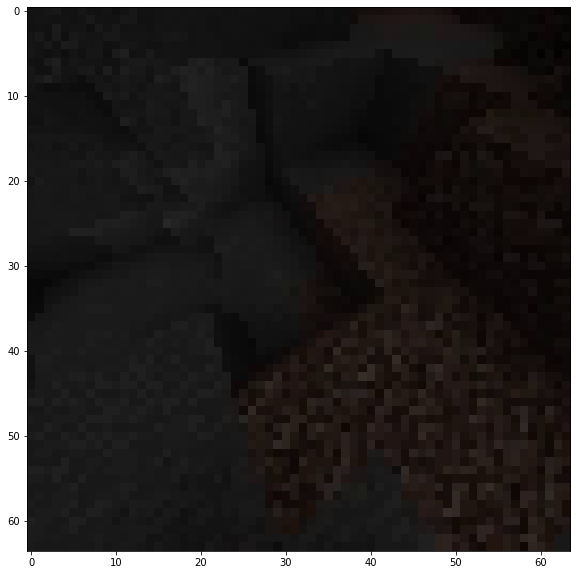

In [8]:
plt.imshow(train_features[0][2][3].permute(1, 2, 0))

In [9]:
class WorldModel(nn.Module):
    def __init__(self, hidden_size=600, vision_size=256, vec_size=64, action_size=64):
        super().__init__()
        obs_size = vision_size + vec_size
        self.vision = VisionModel(vision_size)
#         self.encoder = VisionEncoder(vision_size, activation=nn.ReLU, embed=True)
#         self.decoder = VisionDecoder(vision_size, activation=nn.ReLU)
        self.rnn = nn.GRU(obs_size + action_size, hidden_size, batch_first=True)
        self.predictor_linear = nn.Sequential(nn.Linear(hidden_size, hidden_size), nn.ELU(), nn.LayerNorm(hidden_size))
        self.transition = mdn.MDN(hidden_size, obs_size, 5)
        self.reward = mdn.MDN(hidden_size, 1, 5)
        self.done = nn.Sequential(nn.Linear(hidden_size, 1), nn.Sigmoid())
    
    def forward(self, povs, vecs, actions, hidden=None):
        batch_size, timesteps, C, H, W = povs.shape
        for_cnn = povs.view(timesteps * batch_size, C, H, W)
        recons, encoded = self.vision(for_cnn)
        recons = recons.view(batch_size, timesteps, C, H, W)
        pov_obs = encoded.view(batch_size, timesteps, -1)
        
        obs = torch.cat((pov_obs, vecs), -1)
        
        h, final_h = self.rnn(torch.cat((obs, actions), -1), hidden)
        
        pred = self.predictor_linear(h.reshape(timesteps * batch_size, -1))

        trans_out = self.transition(pred)
        reward_out = self.reward(pred)
        done_out = self.done(pred)
        
        return encoded, recons, obs, h, trans_out, reward_out, done_out
    
    def vae_forward(self, povs):

        recons, encoded = self.vision(povs)
        return recons, (encoded,)
    
    def model_forward(self, obs, actions, hidden=None):
        batch_size = obs.shape[0]
        timesteps = obs.shape[1]
        
        h, final_h = self.rnn(torch.cat((obs, actions), -1), hidden)
        
        pred = self.predictor_linear(h.reshape(timesteps * batch_size, -1))

        trans_out = self.transition(pred)
        reward_out = self.reward(pred)
        done_out = self.done(pred)
        
        return h, trans_out, reward_out, done_out

In [10]:
model = WorldModel()

In [11]:
povs, vecs, actions, rewards, dones = train_features

In [12]:
batch_size, timesteps, C, H, W = povs.shape

In [13]:
outs = model(povs, vecs, actions)

In [14]:
obs = torch.cat((outs[0].view(batch_size, timesteps, -1), vecs), -1)

In [15]:
model_outs = model.model_forward(obs, actions)

In [16]:
import torch.distributions as D

In [17]:
def vae_gaussian_loss(inputs, outputs, latents):
    z, mu, logvar = latents
    recon = -(D.Normal(outputs, torch.ones_like(outputs)).log_prob(inputs).mean())
    kl = autoencoder.kld_loss(mu, logvar)
    return recon + kl, recon, kl

In [18]:
def gaussian_loss(inputs, outputs, latents):
    recon = -(D.Normal(outputs, torch.ones_like(outputs)).log_prob(inputs).mean())
    return recon, recon, recon

In [19]:
def wm_loss(outs, povs, vecs, actions, rewards, dones):
    vae_out, recons, obs, h, trans_out, reward_out, done_out = outs
    
    batch_size, timesteps, C, H, W = povs.shape
    rewards = rewards.view(timesteps * batch_size, -1)
    dones = dones.view(timesteps * batch_size, -1)
    
#     recons_loss = vae_gaussian_loss(povs, recons, vae_out)[0]
    recons_loss = -(D.Normal(recons, torch.ones_like(recons)).log_prob(povs).mean())
    
    # build the target for prediction loss
    #todo shift the obs or figure out a better way to do this
    obs_targets = obs[:, 1:, :]
    pred_total = obs_targets.shape[0] * obs_targets.shape[1]
    obs_targets = obs_targets.reshape(pred_total, -1)
    
    obs_pred = [x[:pred_total, :, :] for x in trans_out]
    
    obs_pred_loss = mdn.gnll_loss(*obs_pred, obs_targets.detach())
    reward_pred_loss = mdn.gnll_loss(*reward_out, torch.log2(rewards+1)/10)
    done_pred_loss = -(D.Bernoulli(done_out).log_prob(dones).mean())
    
    parts = [recons_loss, obs_pred_loss * .01, reward_pred_loss * .05, done_pred_loss * .05]
    
    return sum(parts), *parts

In [20]:
def model_loss(outs, obs, actions, rewards, dones):
    h, trans_out, reward_out, done_out = outs
    batch_size, timesteps, C = rewards.shape
    rewards = rewards.view(timesteps * batch_size, -1)
    dones = dones.view(timesteps * batch_size, -1)
    
    # build the target for prediction loss
    #todo shift the obs or figure out a better way to do this
    obs_targets = obs[:, 1:, :]
    pred_total = obs_targets.shape[0] * obs_targets.shape[1]
    obs_targets = obs_targets.reshape(pred_total, -1)
    
    obs_pred = [x[:pred_total, :, :] for x in trans_out]
    
    obs_pred_loss = mdn.gnll_loss(*obs_pred, obs_targets.detach())
    reward_pred_loss = mdn.gnll_loss(*reward_out, torch.log2(rewards+1)/10)
    done_pred_loss = -(D.Bernoulli(done_out).log_prob(dones).mean())
    
    parts = [obs_pred_loss, reward_pred_loss, done_pred_loss]
    
    return sum(parts), *parts

In [21]:
loss = wm_loss(outs, povs, vecs, actions, rewards, dones)
loss

(tensor(1.0816, grad_fn=<AddBackward0>),
 tensor(1.0014, grad_fn=<NegBackward>),
 tensor(0.0099, grad_fn=<MulBackward0>),
 tensor(0.0174, grad_fn=<MulBackward0>),
 tensor(0.0529, grad_fn=<MulBackward0>))

In [22]:
loss = model_loss(model_outs, obs, actions, rewards, dones)
loss

(tensor(2.3981, grad_fn=<AddBackward0>),
 tensor(0.9923, grad_fn=<NegBackward>),
 tensor(0.3473, grad_fn=<NegBackward>),
 tensor(1.0586, grad_fn=<NegBackward>))

In [23]:
model.cuda()

WorldModel(
  (vision): VisionModel(
    (encoder): VisionEncoder(
      (encoder): Sequential(
        (0): CoordConv2d(
          3, 32, kernel_size=(4, 4), stride=(2, 2)
          (addcoords): AddCoords()
          (conv): Conv2d(5, 32, kernel_size=(4, 4), stride=(2, 2))
        )
        (1): SiLU()
        (2): SkippableLayerNorm()
        (3): CoordConv2d(
          32, 64, kernel_size=(4, 4), stride=(2, 2)
          (addcoords): AddCoords()
          (conv): Conv2d(34, 64, kernel_size=(4, 4), stride=(2, 2))
        )
        (4): SiLU()
        (5): SkippableLayerNorm()
        (6): CoordConv2d(
          64, 128, kernel_size=(4, 4), stride=(2, 2)
          (addcoords): AddCoords()
          (conv): Conv2d(66, 128, kernel_size=(4, 4), stride=(2, 2))
        )
        (7): SiLU()
        (8): SkippableLayerNorm()
        (9): CoordConv2d(
          128, 256, kernel_size=(4, 4), stride=(2, 2)
          (addcoords): AddCoords()
          (conv): Conv2d(130, 256, kernel_size=(4, 4),

# Time to pretrain the vision model

In [24]:
vm = model.vision
vm

VisionModel(
  (encoder): VisionEncoder(
    (encoder): Sequential(
      (0): CoordConv2d(
        3, 32, kernel_size=(4, 4), stride=(2, 2)
        (addcoords): AddCoords()
        (conv): Conv2d(5, 32, kernel_size=(4, 4), stride=(2, 2))
      )
      (1): SiLU()
      (2): SkippableLayerNorm()
      (3): CoordConv2d(
        32, 64, kernel_size=(4, 4), stride=(2, 2)
        (addcoords): AddCoords()
        (conv): Conv2d(34, 64, kernel_size=(4, 4), stride=(2, 2))
      )
      (4): SiLU()
      (5): SkippableLayerNorm()
      (6): CoordConv2d(
        64, 128, kernel_size=(4, 4), stride=(2, 2)
        (addcoords): AddCoords()
        (conv): Conv2d(66, 128, kernel_size=(4, 4), stride=(2, 2))
      )
      (7): SiLU()
      (8): SkippableLayerNorm()
      (9): CoordConv2d(
        128, 256, kernel_size=(4, 4), stride=(2, 2)
        (addcoords): AddCoords()
        (conv): Conv2d(130, 256, kernel_size=(4, 4), stride=(2, 2))
      )
      (10): SiLU()
      (11): SkippableLayerNorm()
  

In [25]:
vm_opt = optim.Adam(vm.parameters(), lr=LEARNING_RATE)

In [26]:
vision_dataset = MineRlImageDataset("data/npy_obtain_diamond")

In [27]:
VISION_BATCH_SIZE = 256

In [28]:
vision_dataloader = DataLoader(
    vision_dataset, batch_size=VISION_BATCH_SIZE, shuffle=True, num_workers=8, pin_memory=True)

In [29]:
vision_dataloader.batch_size, len(vision_dataloader.dataset)

(256, 1916597)

In [30]:
vm_losses = []

In [31]:
import time

In [78]:
loss_steps = 50
epochs = 10

torch.set_grad_enabled(True)

def train_vision(model, optimizer, dataloader, metrics):
        running_loss = []
        update_time = time.time()
        with tqdm(enumerate(dataloader, 0), total=len(dataloader.dataset)/dataloader.batch_size, unit="batch") as t:
            for i, data in t:
                # get the inputs
        #         current_state, action, reward, next_state, done = data
                image = data.permute(0, 3, 1, 2).cuda() / 255

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs, latents = model(image)

                loss = gaussian_loss(image, outputs, latents)
                if isinstance(loss, tuple):
                    loss[0].backward()
                else:
                    loss.backward()

                #     plot_grad_flow(model.named_parameters())

                nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()

                if isinstance(loss, tuple):
                    loss = loss[0].item()
                else:
                    loss = loss.item()
                
                metrics.append(loss)
                running_loss.append(loss)
                
                if time.time() - update_time > 2:
                    string = '[%5d] loss: %.8f' % (i + 1, sum(running_loss) / len(running_loss))
                    t.set_postfix_str(string)
                    running_loss = []
                    update_time = time.time()

for epoch in range(epochs):
    train_vision(vm, vm_opt, vision_dataloader, vm_losses)

NameError: name 'vm' is not defined

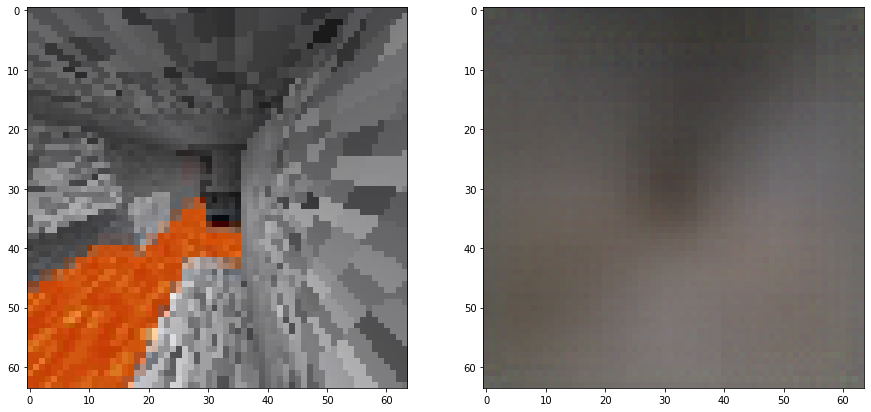

In [48]:
def test_net():
    test_povs = train_features[0]
    batch_size, timesteps, C, H, W = test_povs.shape
    input_data = test_povs.view(timesteps * batch_size, C, H, W)
    vae_outs = model.vae_forward(input_data.cuda())
    op = vae_outs[0].detach().cpu().numpy().transpose(0, 2, 3, 1)
    
    idx = 0 #180 #200
    plt.subplot(1, 2, 1)
    plt.imshow(input_data[idx].permute(1, 2, 0))
    plt.subplot(1, 2, 2)

    plt.imshow(op[idx])
test_net()

# Load a saved vision model if needed

In [24]:
model.vision.load_state_dict(torch.load("models/vision_10_epochs.mdl"))

<All keys matched successfully>

# Train the world model

In [25]:
BATCH_SIZE = 32
SEQUENCE_LENGTH = 16

In [26]:
dataset = MineRlSequenceDataset("data/npy_obtain_diamond", SEQUENCE_LENGTH)

In [27]:
train_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)

In [28]:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [29]:
losses = []
raw_losses = []
pov_losses = []
vec_losses = []
prediction_losses = []
reward_losses = []
done_losses = []

In [30]:
loss_steps = 50
epochs = 10

torch.set_grad_enabled(True)
for epoch in range(epochs):
    running_loss = 0
    with tqdm(enumerate(train_dataloader, 0), total=len(dataset)/(BATCH_SIZE), unit="batch") as t:
        for i, data in t:
            # get the inputs
            optimizer.zero_grad()
            data = [x.cuda() for x in data]
            povs, vecs, actions, rewards, dones = data
            batch_size, timesteps, C, H, W = povs.shape
            
            with torch.no_grad():
                encoded = model.vision.encoder(povs.view(timesteps * batch_size, C, H, W))
            
            obs = torch.cat((encoded.view(batch_size, timesteps, -1), vecs), -1)
            
            outs = model.model_forward(obs, actions)
            loss = model_loss(outs, obs, actions, rewards, dones)
        
            loss[0].backward()
#             plot_grad_flow(model.named_parameters())
            nn.utils.clip_grad_value_(model.parameters(), 1.0)
            optimizer.step()
            
            loss = [x.item() for x in loss]
            
            raw_losses.append(loss[0])
            prediction_losses.append(loss[1])
            reward_losses.append(loss[2])
            done_losses.append(loss[3])

            # print statistics
            running_loss += loss[0]
            if i % loss_steps == loss_steps - 1:  # print every N mini-batches
                string = '[%d, %5d] loss: %.8f' % (epoch + 1, i + 1, running_loss / loss_steps)
                t.set_postfix_str(string)
                losses.append(running_loss / loss_steps)
                running_loss = 0.0

59894batch [34:38, 28.82batch/s, [1, 59850] loss: -6.17781176]                                
 11%|█▌            | 6680/59893.1875 [03:52<30:50, 28.76batch/s, [2,  6650] loss: -6.29227754]


KeyboardInterrupt: 

In [ ]:
loss = None
batch_size, timesteps, C, H, W

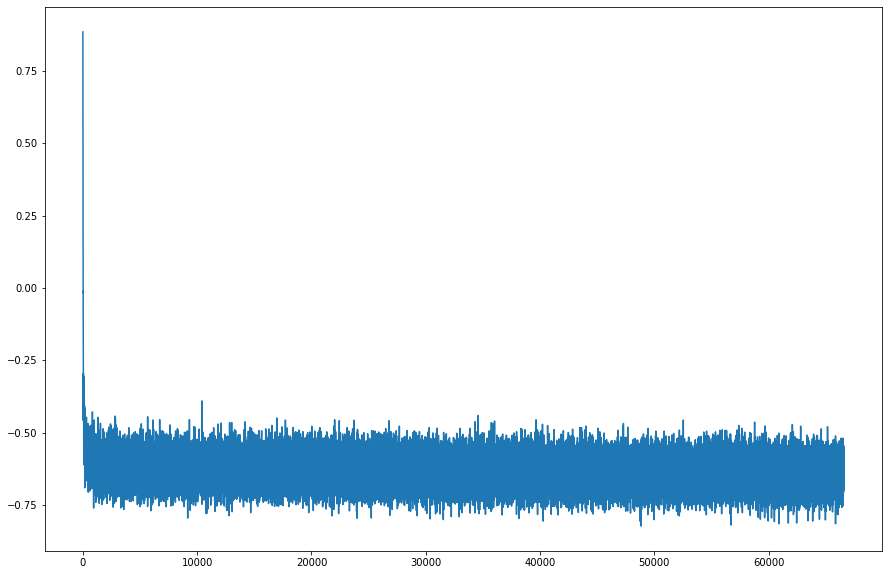

In [31]:
plt.plot(prediction_losses)

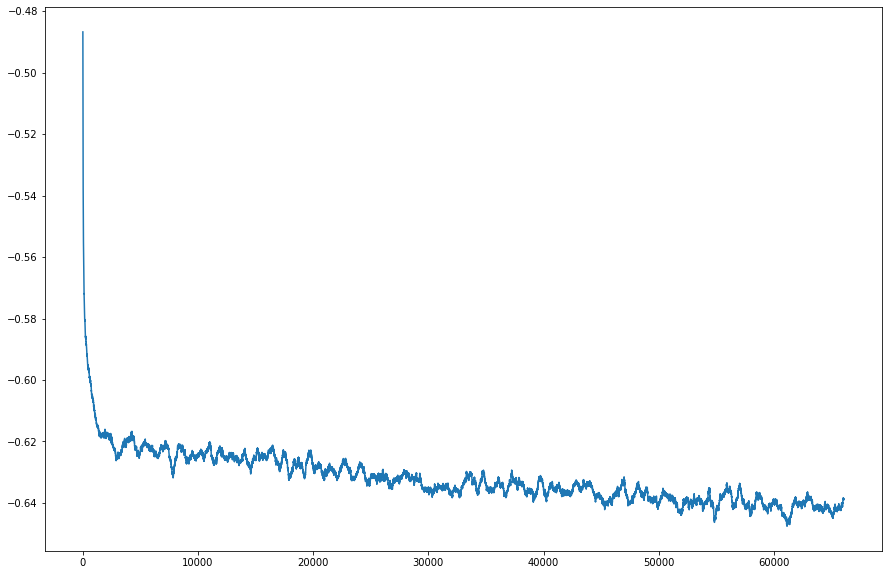

In [32]:
plt.plot(np.convolve(np.asarray(prediction_losses), np.ones(500)/500, mode='valid'))

# Test image reconstruction

In [48]:
test_povs = train_features[0]
batch_size, timesteps, C, H, W = test_povs.shape
input_data = test_povs.view(timesteps * batch_size, C, H, W)

In [49]:
vae_outs = model.vae_forward(input_data.cuda())

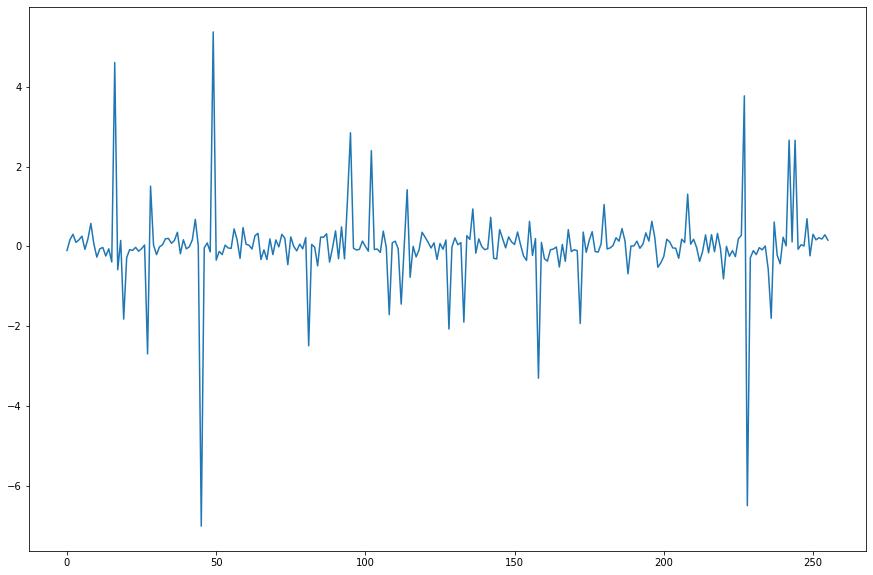

In [50]:
plt.plot(vae_outs[1][0][0].detach().cpu())

In [51]:
batch_size, timesteps, C, H, W

(8, 32, 3, 64, 64)

In [52]:
op = vae_outs[0].detach().cpu().numpy().transpose(0, 2, 3, 1)

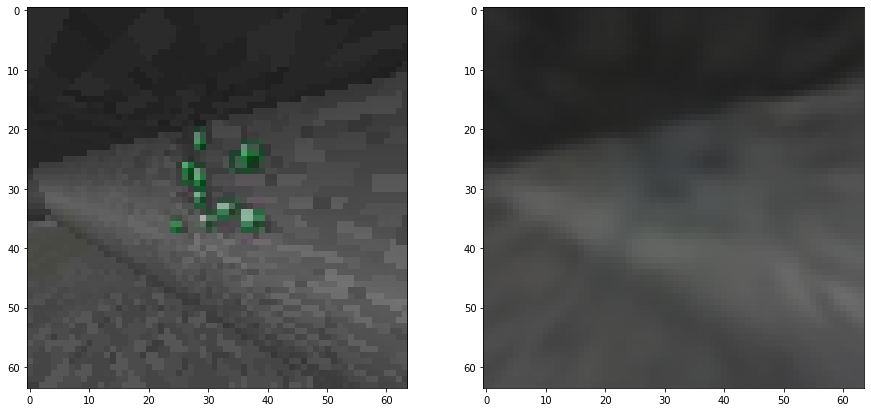

In [61]:
idx = 6+32*6 #180 #200
plt.subplot(1, 2, 1)
plt.imshow(input_data[idx].permute(1, 2, 0))
plt.subplot(1, 2, 2)

plt.imshow(op[idx])

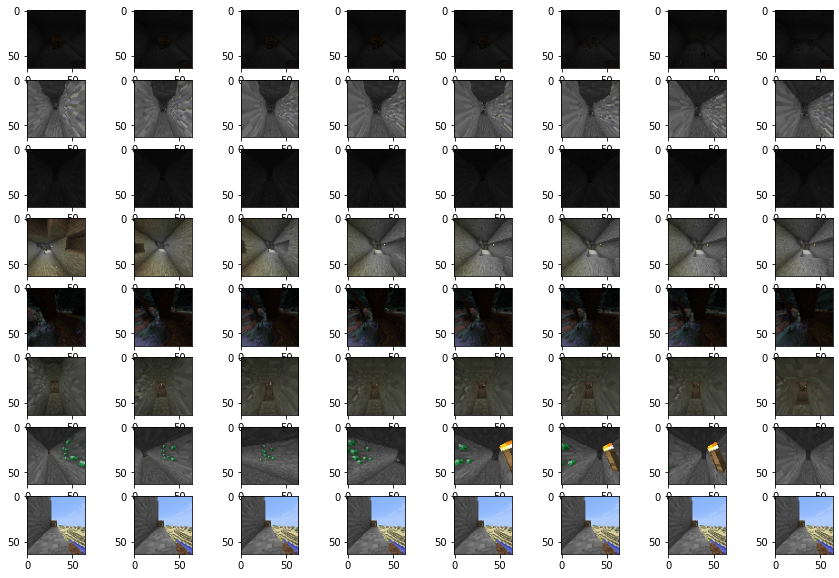

In [54]:
height = 8
width = 8

for i in range(height):
    for j in range(width):
        idx = i*width+j
        plt.subplot(height, width, idx+1)
        plt.imshow(input_data[idx*4].permute(1, 2, 0))

# Test Dreaming

In [33]:
torch.set_grad_enabled(False)

In [34]:
test_povs, test_vecs, test_actions, test_rewards, test_dones = train_features
batch_size, timesteps, C, H, W = test_povs.shape

In [35]:
with torch.no_grad():
    _, encoded = model.vision(test_povs.view(timesteps * batch_size, C, H, W).cuda())

obs = torch.cat((encoded.view(batch_size, timesteps, -1), test_vecs.cuda()), -1)

In [40]:
# seed the model with the first four frames
seed_obs = obs[:, :4, :]
seed_act = test_actions.cuda()[:, :4, :]
seed_obs.shape

torch.Size([8, 4, 320])

In [41]:
with torch.no_grad():
    outs = model.model_forward(seed_obs, seed_act)

In [42]:
h, trans_out, reward_out, done_out = outs

In [43]:
h.shape, trans_out[0].shape

(torch.Size([8, 4, 600]), torch.Size([32, 320, 5]))

In [44]:
# sample the transition, then reconstruct it
sampled = mdn.distribution(*trans_out).sample().view(batch_size, 4, -1)

In [45]:
sampled.shape

torch.Size([8, 4, 320])

In [46]:
sampled_encoded = sampled[:, -1, :-64]
sampled_encoded.shape

torch.Size([8, 256])

In [47]:
recons = model.vision.decoder(F.layer_norm(sampled_encoded, sampled_encoded.shape[1:]))

In [48]:
seed_recons = model.vision.decoder(encoded).view(batch_size, timesteps, C, H, W).cpu().numpy().transpose(0, 1, 3, 4, 2)
seed_recons.shape

(8, 32, 64, 64, 3)

In [52]:
tps = test_povs.cpu().numpy().transpose(0, 1, 3, 4, 2)

In [53]:
op = recons.detach().cpu().numpy().transpose(0, 2, 3, 1)

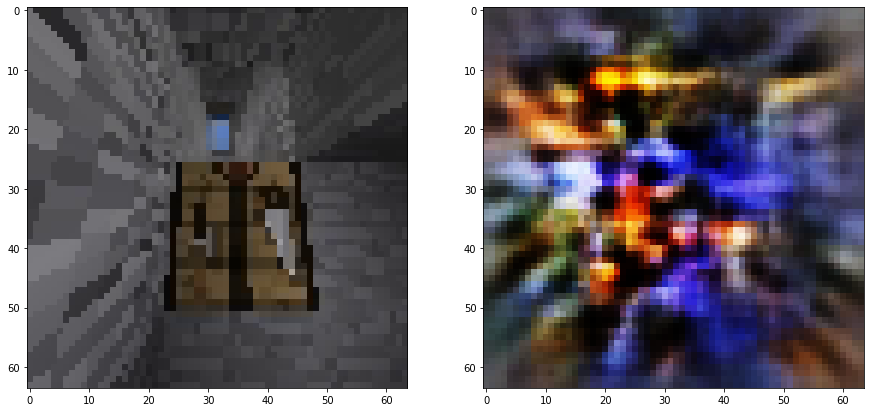

In [54]:
idx = 7
plt.subplot(1, 2, 1)
plt.imshow(tps[idx][4])
plt.subplot(1, 2, 2)

plt.imshow(op[idx])

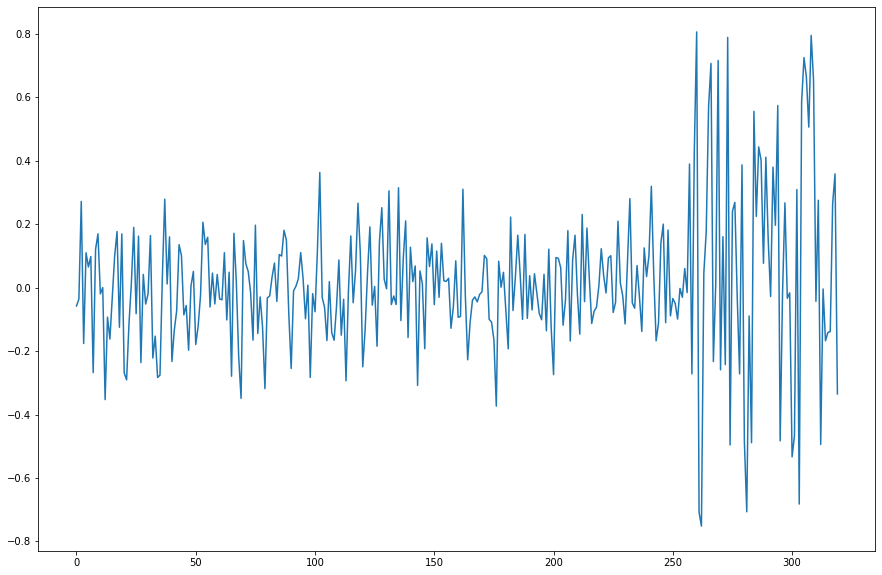

In [56]:
plt.plot(obs[7, 4].cpu())

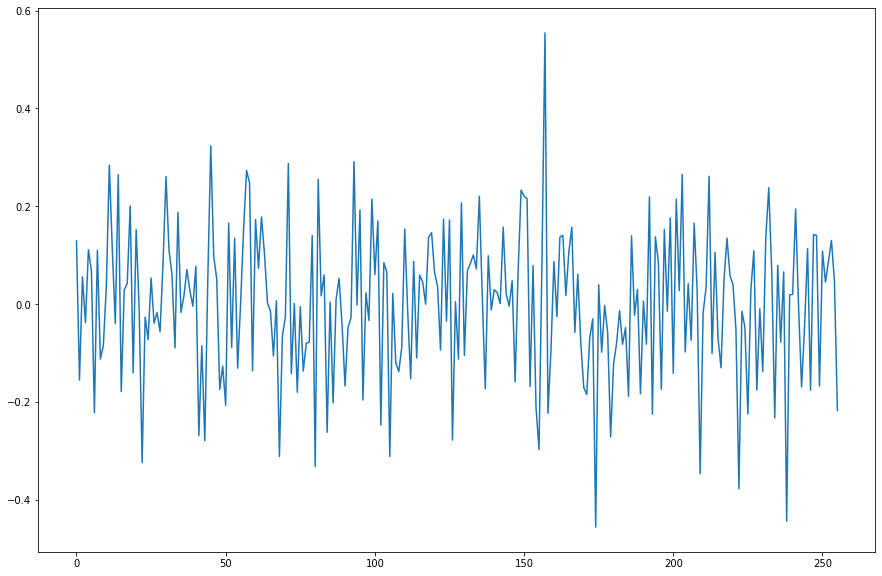

In [57]:
plt.plot(sampled_encoded[7].cpu())

In [1]:
3

3

In [75]:
one_data = next(iter(train_dataloader))
one_data[0].shape

torch.Size([8, 32, 3, 64, 64])

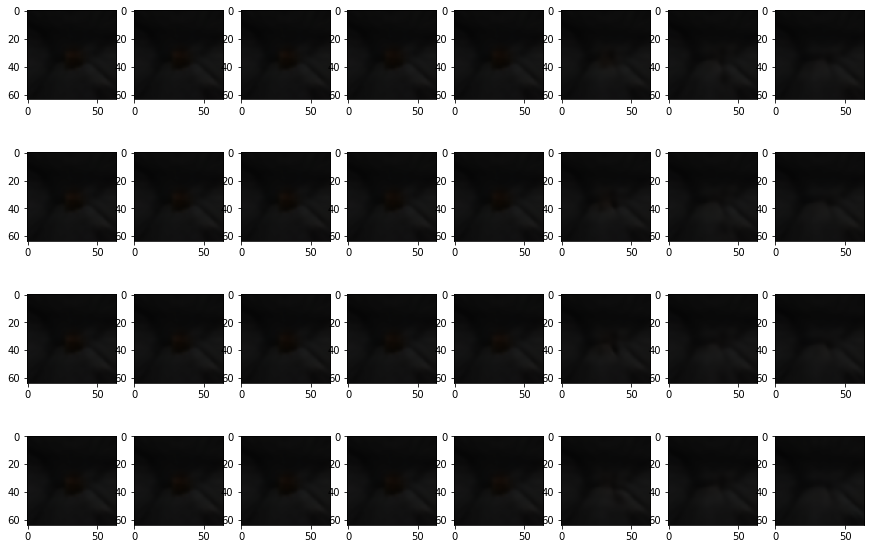

In [117]:
height = 4
width = 8

for i in range(height):
    for j in range(width):
        idx = i*width+j
        plt.subplot(height, width, idx+1)
        plt.imshow(seed_recons[j][i])

In [174]:
povs = one_data[0]
batch_size, timesteps, C, H, W = povs.shape
pov_data = povs.view(timesteps * batch_size, C, H, W)

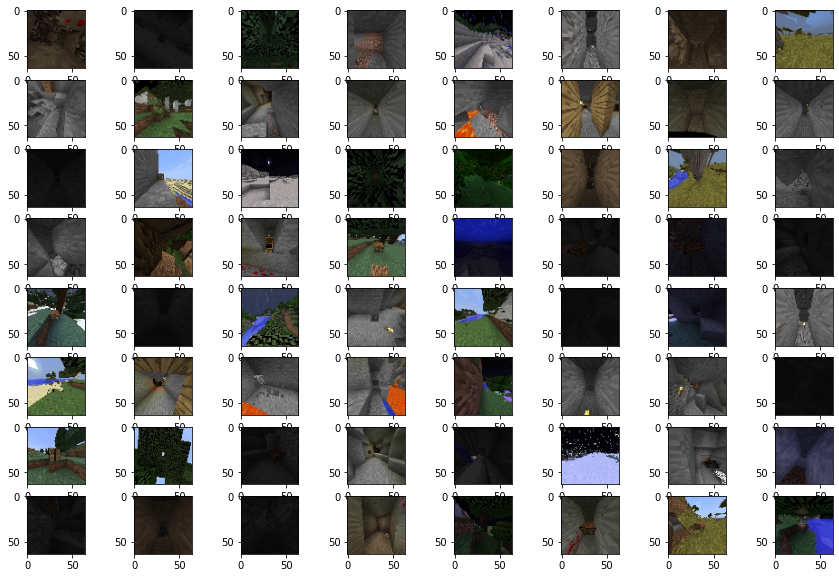

In [121]:
height = 8
width = 8

for i in range(height):
    for j in range(width):
        idx = i*width+j
        plt.subplot(height, width, idx+1)
        plt.imshow(pov_data[idx].permute(1, 2, 0))

In [111]:
input_data[idx].permute(1, 2, 0)

tensor([[[0.0431, 0.0431, 0.0431],
         [0.0667, 0.0667, 0.0667],
         [0.0667, 0.0667, 0.0667],
         ...,
         [0.0353, 0.0353, 0.0353],
         [0.0784, 0.0784, 0.0784],
         [0.0863, 0.0863, 0.0863]],

        [[0.0471, 0.0471, 0.0471],
         [0.0431, 0.0431, 0.0431],
         [0.0627, 0.0627, 0.0627],
         ...,
         [0.0627, 0.0627, 0.0627],
         [0.0980, 0.0980, 0.0980],
         [0.0706, 0.0706, 0.0706]],

        [[0.0510, 0.0510, 0.0510],
         [0.0471, 0.0471, 0.0471],
         [0.0627, 0.0627, 0.0627],
         ...,
         [0.0706, 0.0706, 0.0706],
         [0.0824, 0.0745, 0.0667],
         [0.0667, 0.0588, 0.0510]],

        ...,

        [[0.0902, 0.0902, 0.0902],
         [0.0902, 0.0902, 0.0902],
         [0.0784, 0.0784, 0.0784],
         ...,
         [0.0706, 0.0706, 0.0706],
         [0.0667, 0.0667, 0.0667],
         [0.0667, 0.0667, 0.0667]],

        [[0.0902, 0.0902, 0.0902],
         [0.0902, 0.0902, 0.0902],
         [0.

In [57]:
from delve import CheckLayerSat
import datetime
import os

In [58]:
metrics_path = "metrics/" + datetime.datetime.now().isoformat() + "/"
metrics_path

'metrics/2021-09-22T07:44:12.253026/'

In [59]:
os.makedirs(metrics_path)

In [60]:
tracker = CheckLayerSat(metrics_path + "my_experiment", save_to="plotcsv", modules=model, device=next(model.parameters()).device)    

added layer vision-encoder-encoder-0
Skipping vision-encoder-encoder-1
added layer vision-encoder-encoder-2
Skipping vision-encoder-encoder-3
added layer vision-encoder-encoder-4
Skipping vision-encoder-encoder-5
added layer vision-encoder-encoder-6
Skipping vision-encoder-encoder-7
Skipping vision-encoder-encoder-8
added layer vision-encoder-encoder-9
added layer vision-decoder-decoder-0
Skipping vision-decoder-decoder-1
Skipping vision-decoder-decoder-2
Skipping vision-decoder-decoder-3
Skipping vision-decoder-decoder-4
Skipping vision-decoder-decoder-5
Skipping vision-decoder-decoder-6
Skipping vision-decoder-decoder-7
Skipping vision-decoder-decoder-8
Skipping vision-decoder-decoder-9
Skipping rnn
added layer predictor_linear-0
Skipping predictor_linear-1
added layer transition-pi-0
Skipping transition-pi-1
added layer transition-mu
added layer transition-sigma-0
Skipping transition-sigma-1
added layer reward-pi-0
Skipping reward-pi-1
added layer reward-mu
added layer reward-sigma-

In [78]:
outs = model(povs, vecs, actions)

metrics/2021-09-22T07:44:12.253026/my_experiment_lsat_train_epoch_0.png


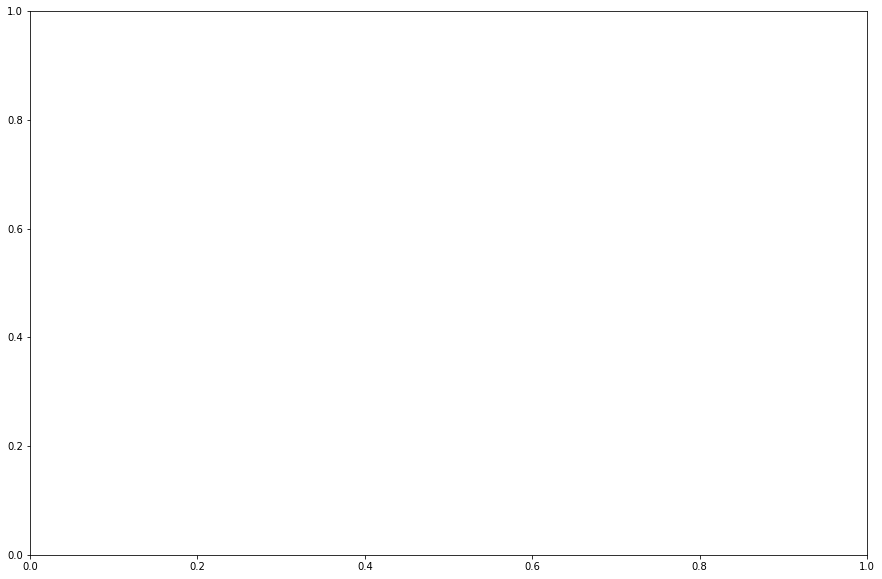

In [79]:
tracker.add_saturations()

In [31]:
1/0.08

12.5